In [3]:
import os
import sys
import glob
import json
import click
import torch
import numpy as np

from pycocotools import mask
from PIL import Image
from PIL import ImageDraw
from torch import nn

sys.path.append("..")
from post_processing import remove_connected_components

sys.path.append("/home/amvernet/dhSegment-torch/")
from dh_segment_torch.data.annotation import AnnotationPainter, AnnotationReader, VIA2Reader
from dh_segment_torch.data import ColorLabels

In [14]:
images_path = "/scratch/students/amvernet/datasets/images"
predictions_path = "/scratch/students/amvernet/experiments/2_B1_000/mmDetection_predictions/0/B1_test"
cc_threshold = 0.005
score_threshold = 0.05

predictions_path = os.path.abspath(predictions_path)
dataset_name = os.path.basename(predictions_path)
run_name = os.path.basename(os.path.dirname(predictions_path))
experiment_path = os.path.abspath(os.path.join(predictions_path, "../../.."))
experiment_name = os.path.basename(experiment_path)

color_labels = ColorLabels.from_labels_json_file(os.path.join(experiment_path, "color_labels.json"))
labels = sorted(color_labels.labels)
colors = [color_labels.colors[color_labels.labels.index(label)] for label in labels]

annotations_path = os.path.join(experiment_path, f"via_annotations_scaled_{dataset_name}.json")
with (open(annotations_path, "r")) as f:
    annotations = json.loads(f.read())
    
predictions_path = os.path.join(predictions_path, "predictions.segm.json")
with (open(predictions_path, "rb")) as f:
    predictions = json.load(f)
predictions = [x for x in predictions if x['score'] >= score_threshold]

In [11]:
pid_test = 'courriergdl-1846-04-01-a-p0004'

results = {}

for prediction in predictions:
    pid = prediction['image_id']
    if pid == pid_test:
        if pid not in results:
            results[pid] = {}

        category_id = prediction['category_id'] + 1
        if "pred" not in results[pid]:
            prediction_mask = mask.decode(prediction['segmentation'])
            results[pid]["pred"] = np.zeros((len(labels), prediction_mask.shape[0], prediction_mask.shape[1]), dtype=np.uint8)
            results[pid]["pred"][category_id] = prediction_mask
        else:
            results[pid]["pred"][category_id] = (results[pid]["pred"][category_id] | mask.decode(prediction['segmentation']))

In [17]:
annotation = annotations[pid_test]
image = Image.open(os.path.join(images_path, pid_test + ".png"))
original_shape = image.width, image.height
ground_truth = np.zeros((len(labels), original_shape[1], original_shape[0]), dtype=np.uint8)

for region in annotation["regions"]:
    shape = region['shape_attributes']
    if shape['name'] == 'rect':
        x, y, w, h = shape['x'], shape['y'], shape['width'], shape['height']
        label = labels.index(region['region_attributes']['label'])
        ground_truth[label, y:y+h, x:x+w] = 1
    elif shape['name'] == 'polygon':
        color = labels.index(region['region_attributes']['label'])
        img = Image.new('L', original_shape, 0)
        polygon_coordinates = [(x, y) for x, y in zip(shape['all_points_x'], shape['all_points_y'])]
        ImageDraw.Draw(img).polygon(polygon_coordinates, outline=1, fill=1)
        m = np.array(img)
        np.putmask(ground_truth[label], m, 1)
    else:
        raise NotImplementedError

if pid_test not in results:
    results[pid_test] = {}

results[pid_test]["gt"] = ground_truth

if 'pred' not in results[pid_test]:
    results[pid_test]["pred"] = np.zeros(ground_truth.shape)

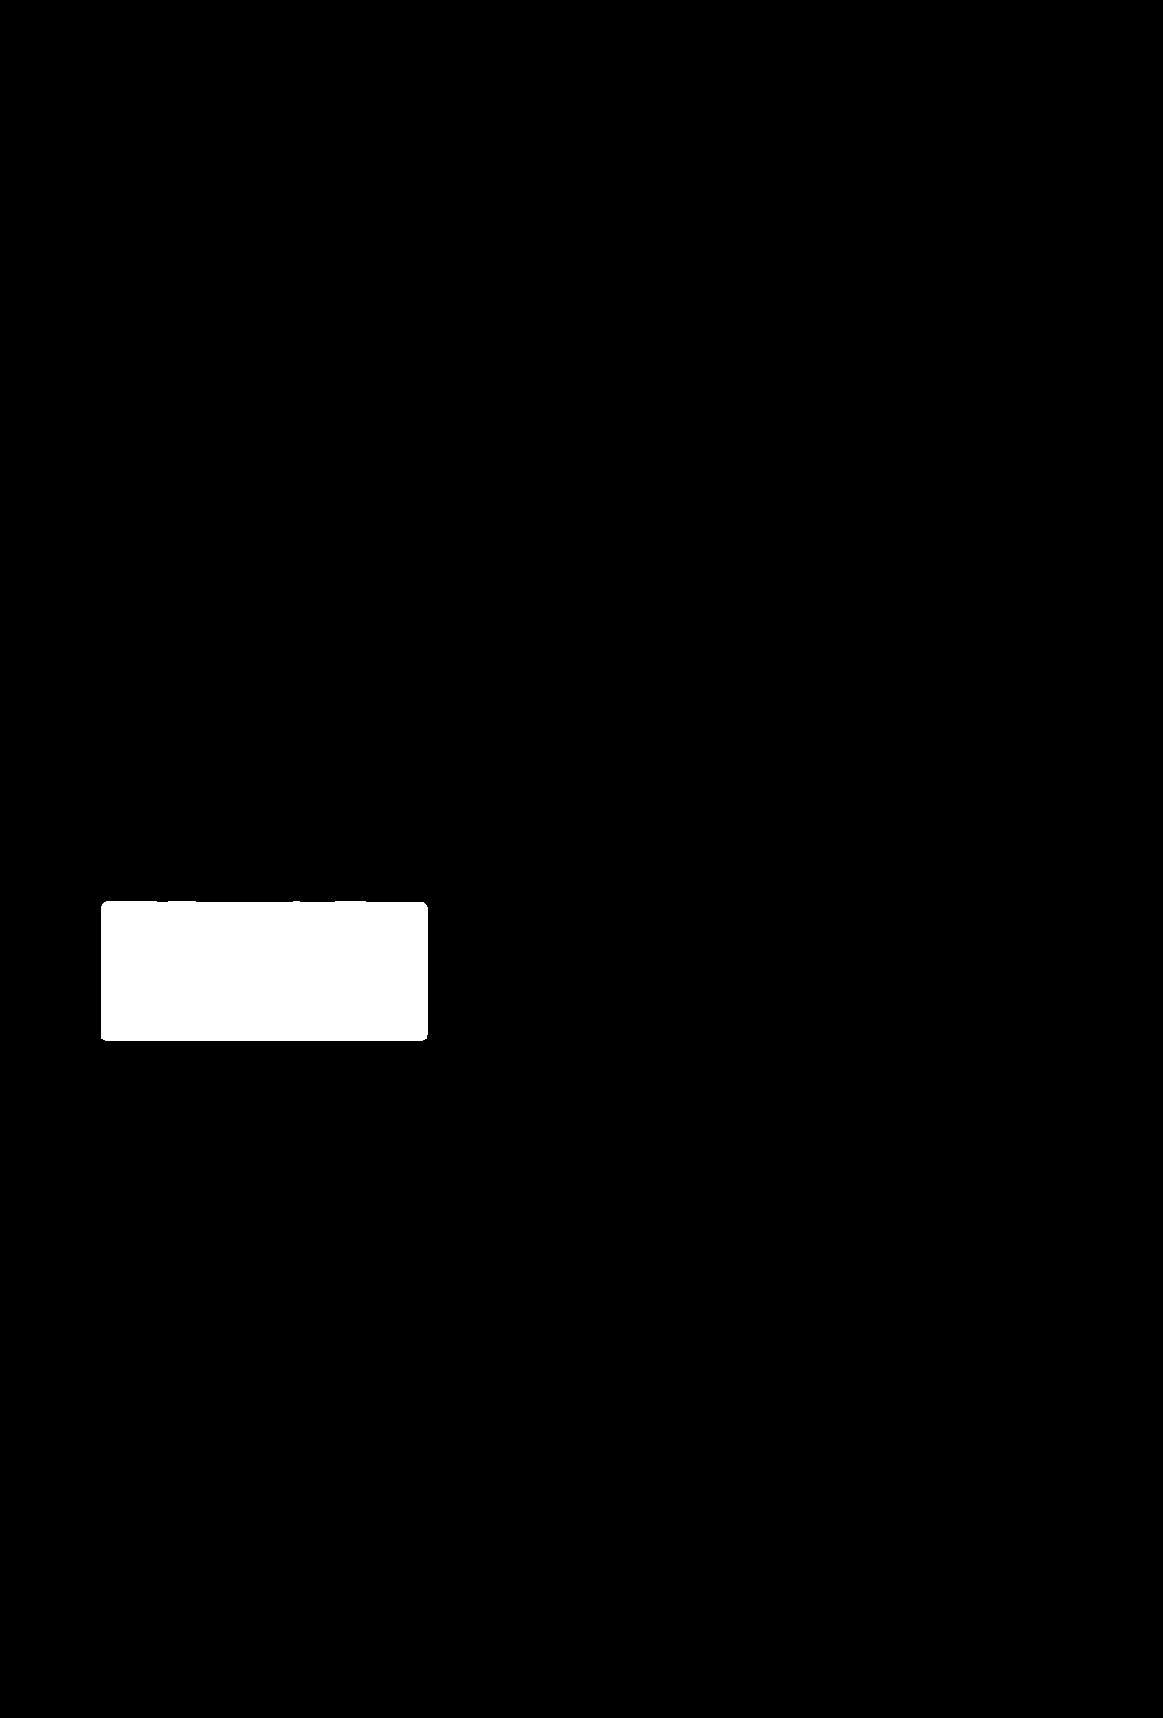

In [18]:
Image.fromarray(results[pid_test]['pred'][2].astype(np.uint8)*255)

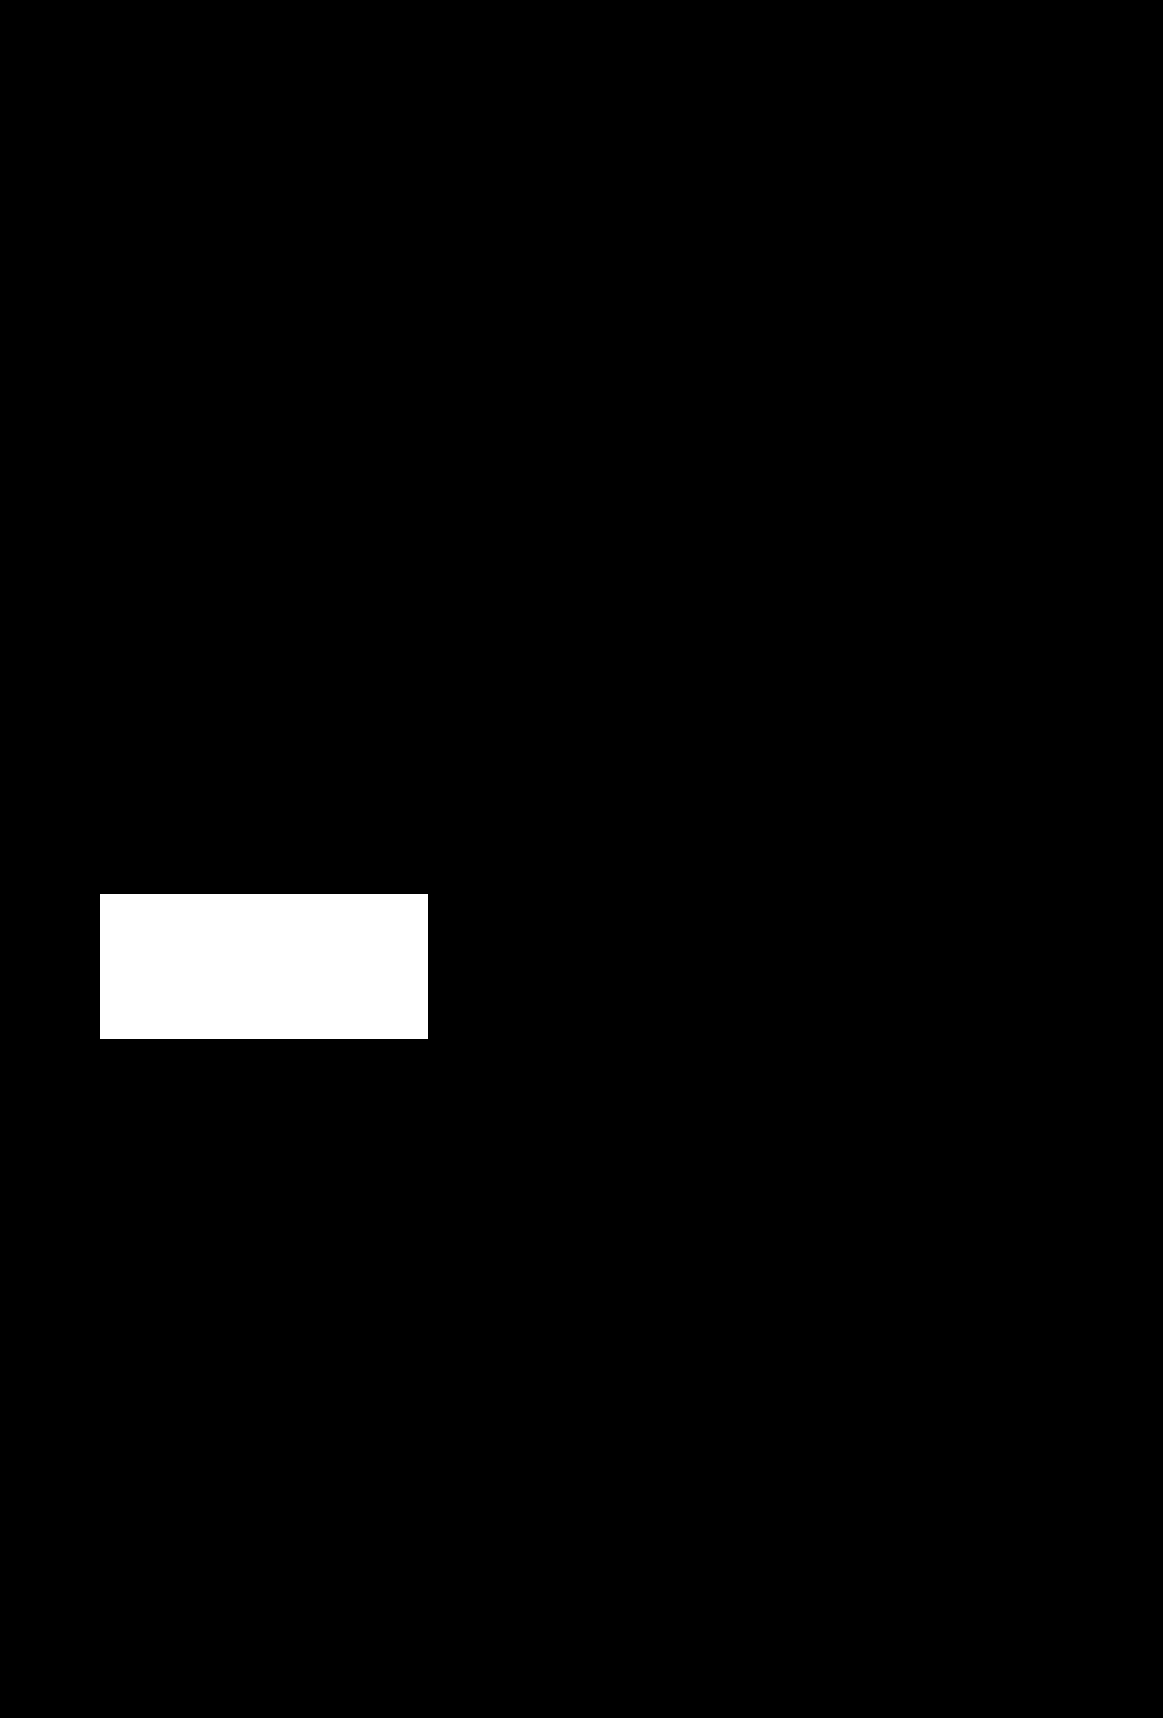

In [13]:
Image.fromarray(results[pid_test]['gt'][2].astype(np.uint8)*255)

In [23]:
print("The IoU of every predictions is being computed...")
for pid, v in tqdm(list(results.items())):
    if pid == 'luxland-1974-05-10-a-p0011':
        gt = np.argmax(v['gt'], axis=0)
        gt = np.expand_dims(gt, axis=2)
        m = nn.Upsample(size=gt.shape[:-1], mode='nearest')

        if 'pred' in v:
            pred = torch.from_numpy(v['pred']).unsqueeze(0)
            pred = np.array(m(pred).squeeze())
            pred = np.argmax(pred, axis=0)# because we only have one class here (no background), when we squeeze it removes dim 0 and 1 because they're (1,1,w,h)
            pred = np.expand_dims(pred, axis=2)
            pred = remove_connected_components(pred, cc_threshold)
        else:
            pred = np.zeros(gt.shape, dtype=np.uint8)

        intersection = np.unique(pred & gt, return_counts=True)
        intersection = {i: val for i, val in zip(intersection[0], intersection[1])}
        union = np.unique(pred | gt, return_counts=True)
        union = {i: val for i, val in zip(union[0], union[1])}

        results[pid]['iou'] = {}
        for i, label in list(enumerate(color_labels.labels))[1:]:
            if i not in union:
                iou = None
            elif i not in intersection:
                iou = 0
            else:
                iou = intersection[i]/union[i]

            results[pid]['iou'][label] = iou

        miou = [v for k, v in results[pid]['iou'].items() if v is not None]
        results[pid]['miou'] = np.mean(miou) if len(miou) > 0 else None

    results_path = os.path.join(experiment_path, "mmDetection_results", run_name, dataset_name)
    os.makedirs(results_path, exist_ok=True)

    #with open(os.path.join(results_path, f"IoU_{score_threshold}.json"), "w") as f:
     #   results_dump = {k: {'iou': v['iou'], 'miou': v['miou']} for k, v in results.items()}
      #  json.dump(results_dump, f)

The IoU of every predictions is being computed...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1654.12it/s]


In [18]:
results_filtered = {k: v for k, v in results.items() if k == pid_test}

for pid, result in tqdm(results_filtered.items()):
    image = Image.open(os.path.join("/scratch/students/amvernet/datasets/images/", pid + ".png"))
    shape = (result['gt'].shape[2], result['gt'].shape[1])
    image = image.resize(shape)
    image = np.asarray(image)

    m = nn.Upsample(size=result['gt'].shape[1:], mode='nearest')
    pred = torch.from_numpy(result['pred']).unsqueeze(0)
    pred = np.array(m(pred).squeeze())

    prediction = image//2
    ground_truth = image//2
    for i, color in list(enumerate(colors))[1:]:
        pred_i = np.expand_dims(pred[i], axis=2)
        pred_i = np.round(pred_i)
        pred_i = remove_connected_components(pred_i, cc_threshold)
        pred_i = (pred_i[:,:,:]*color).astype(np.uint8)
        prediction += pred_i//2

        gt_i = np.expand_dims(result['gt'][i], axis=2)
        gt_i = (gt_i[:,:,:]*color).astype(np.uint8)
        ground_truth += gt_i//2

100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


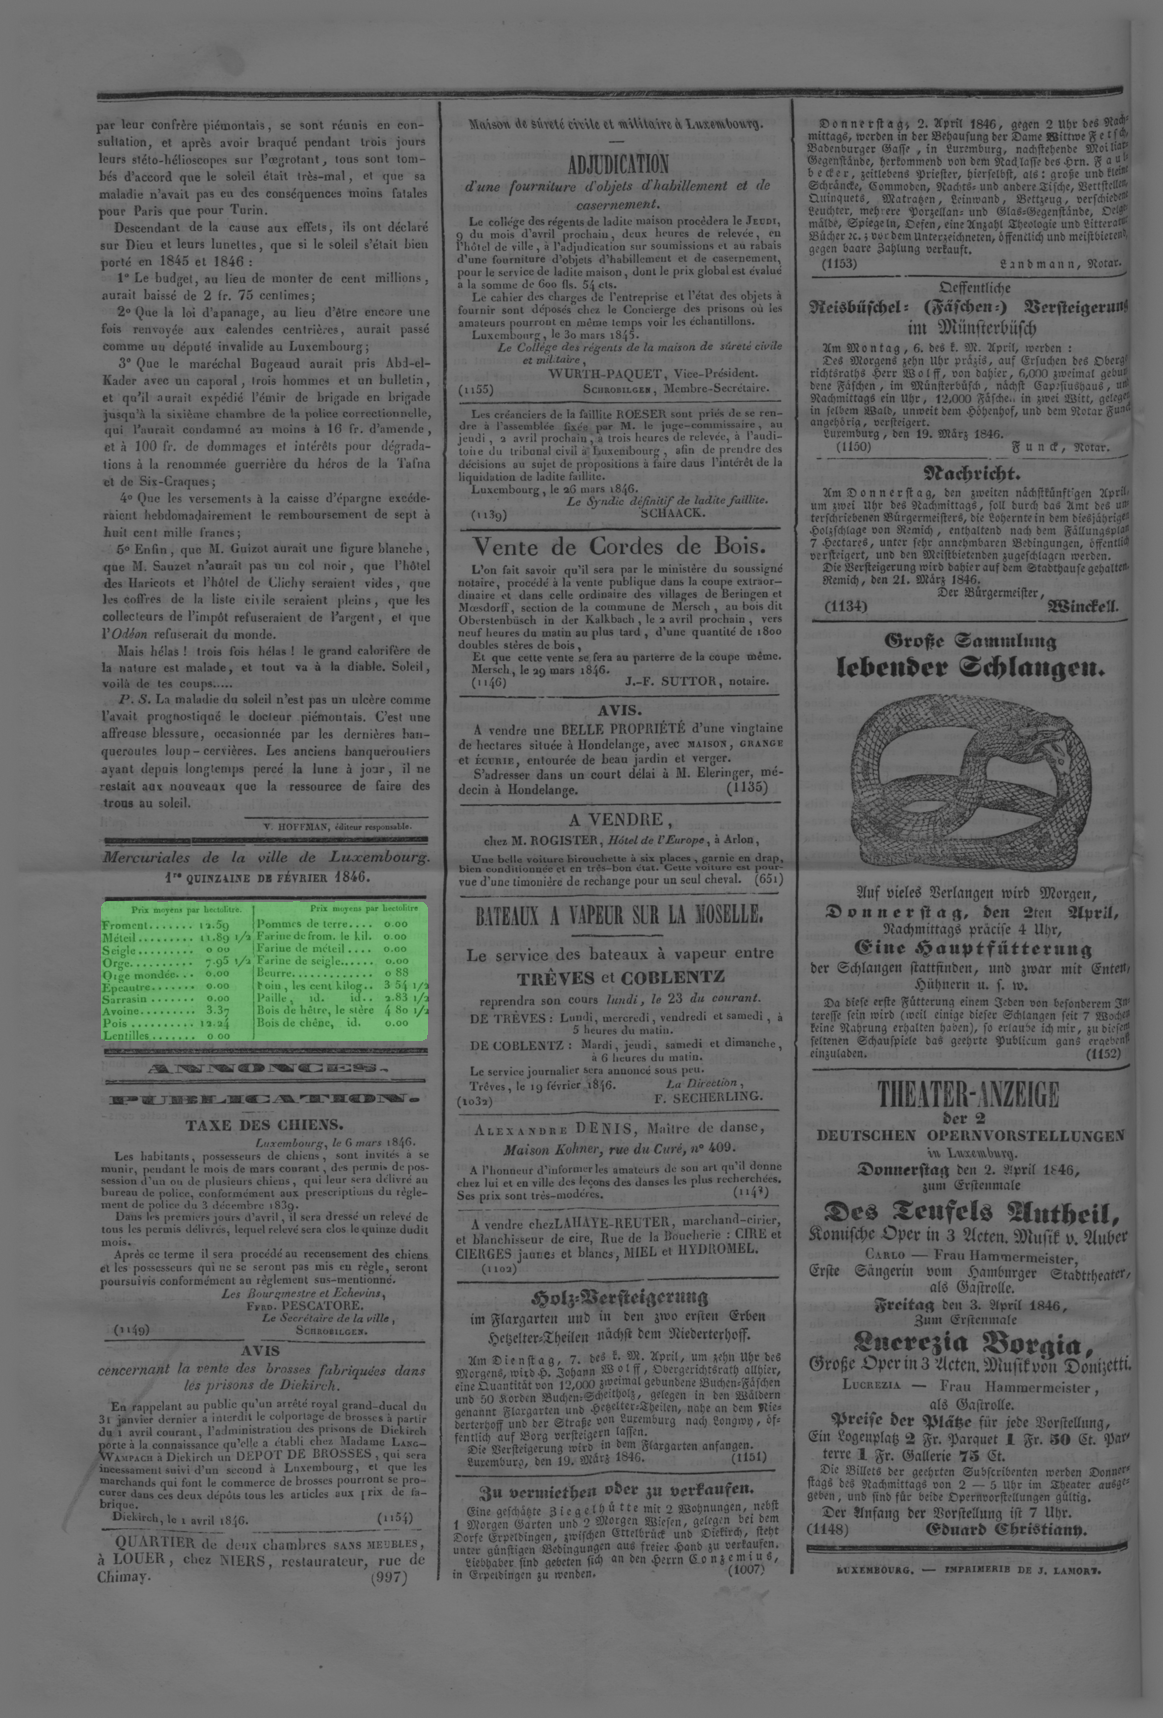

In [19]:
Image.fromarray(prediction)

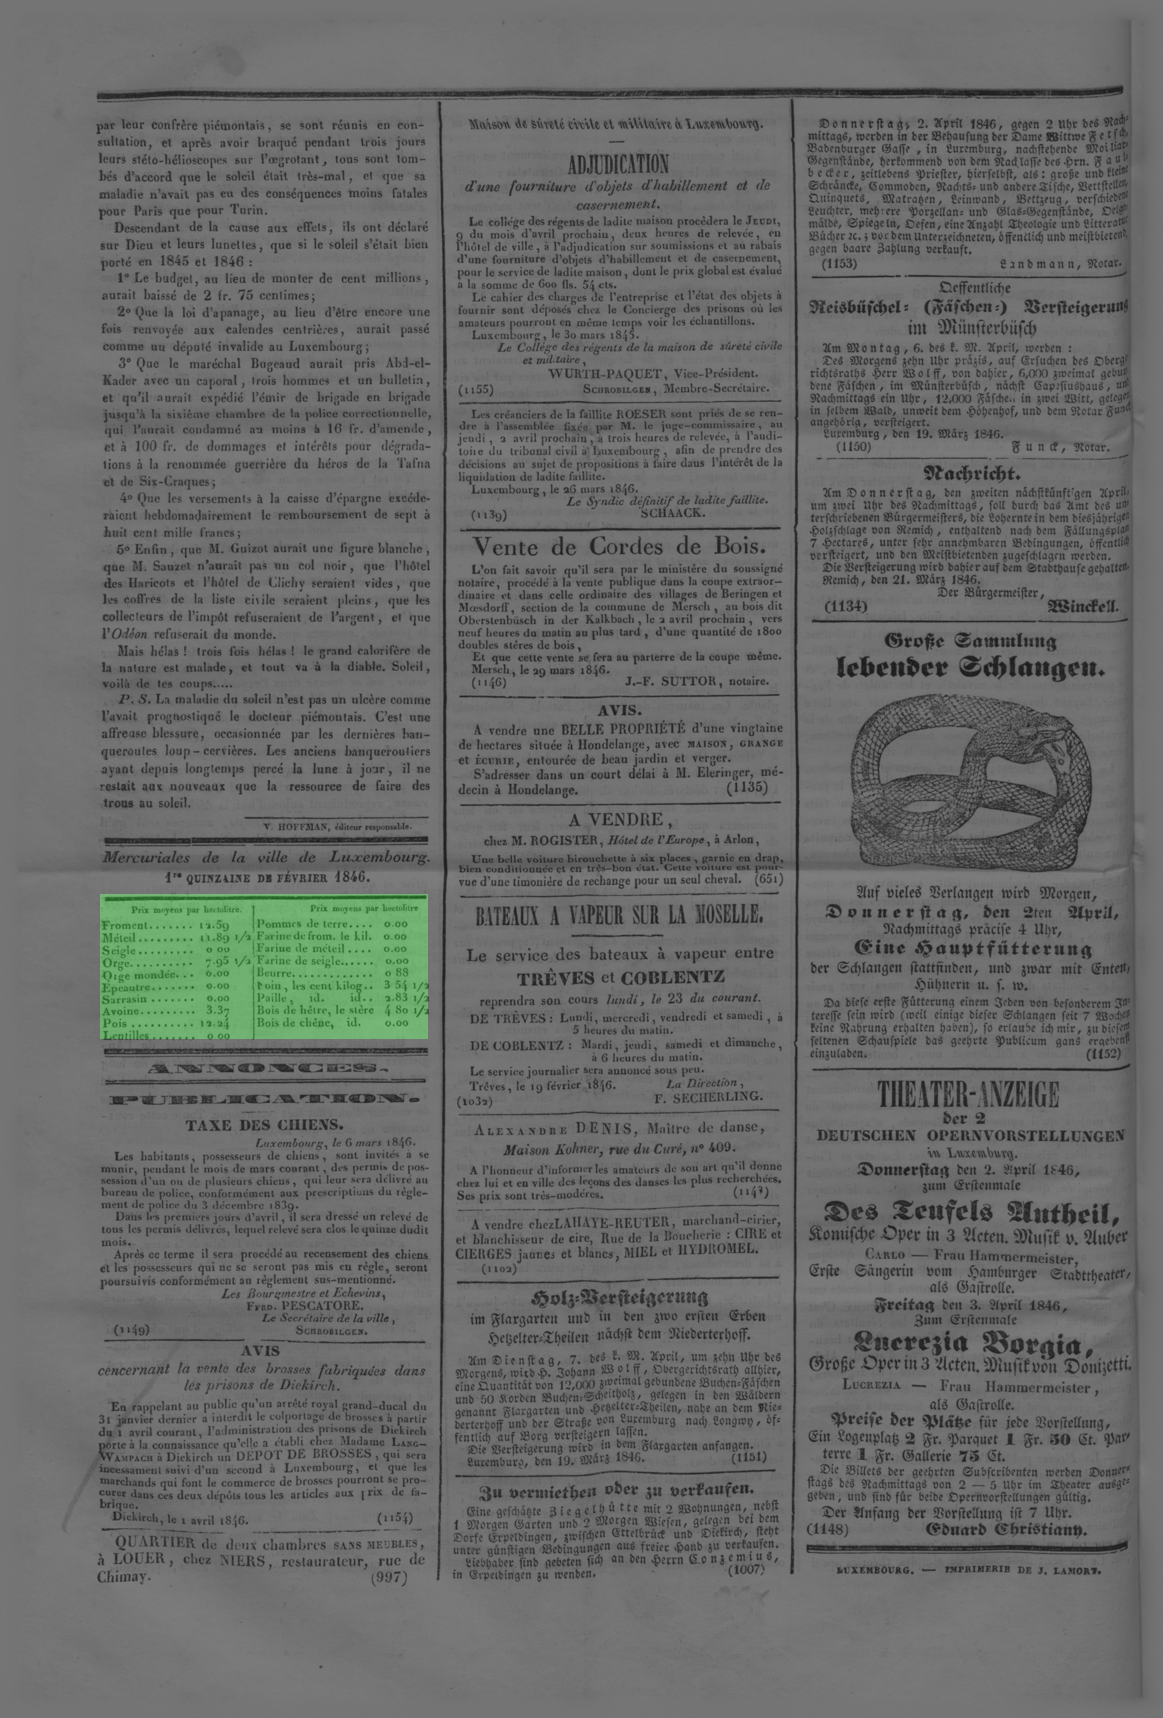

In [20]:
Image.fromarray(ground_truth)